=== VC FUND OPTIMIZATION ANALYSIS ===
Total combinations analyzed: 840
Simulations per combination: 500


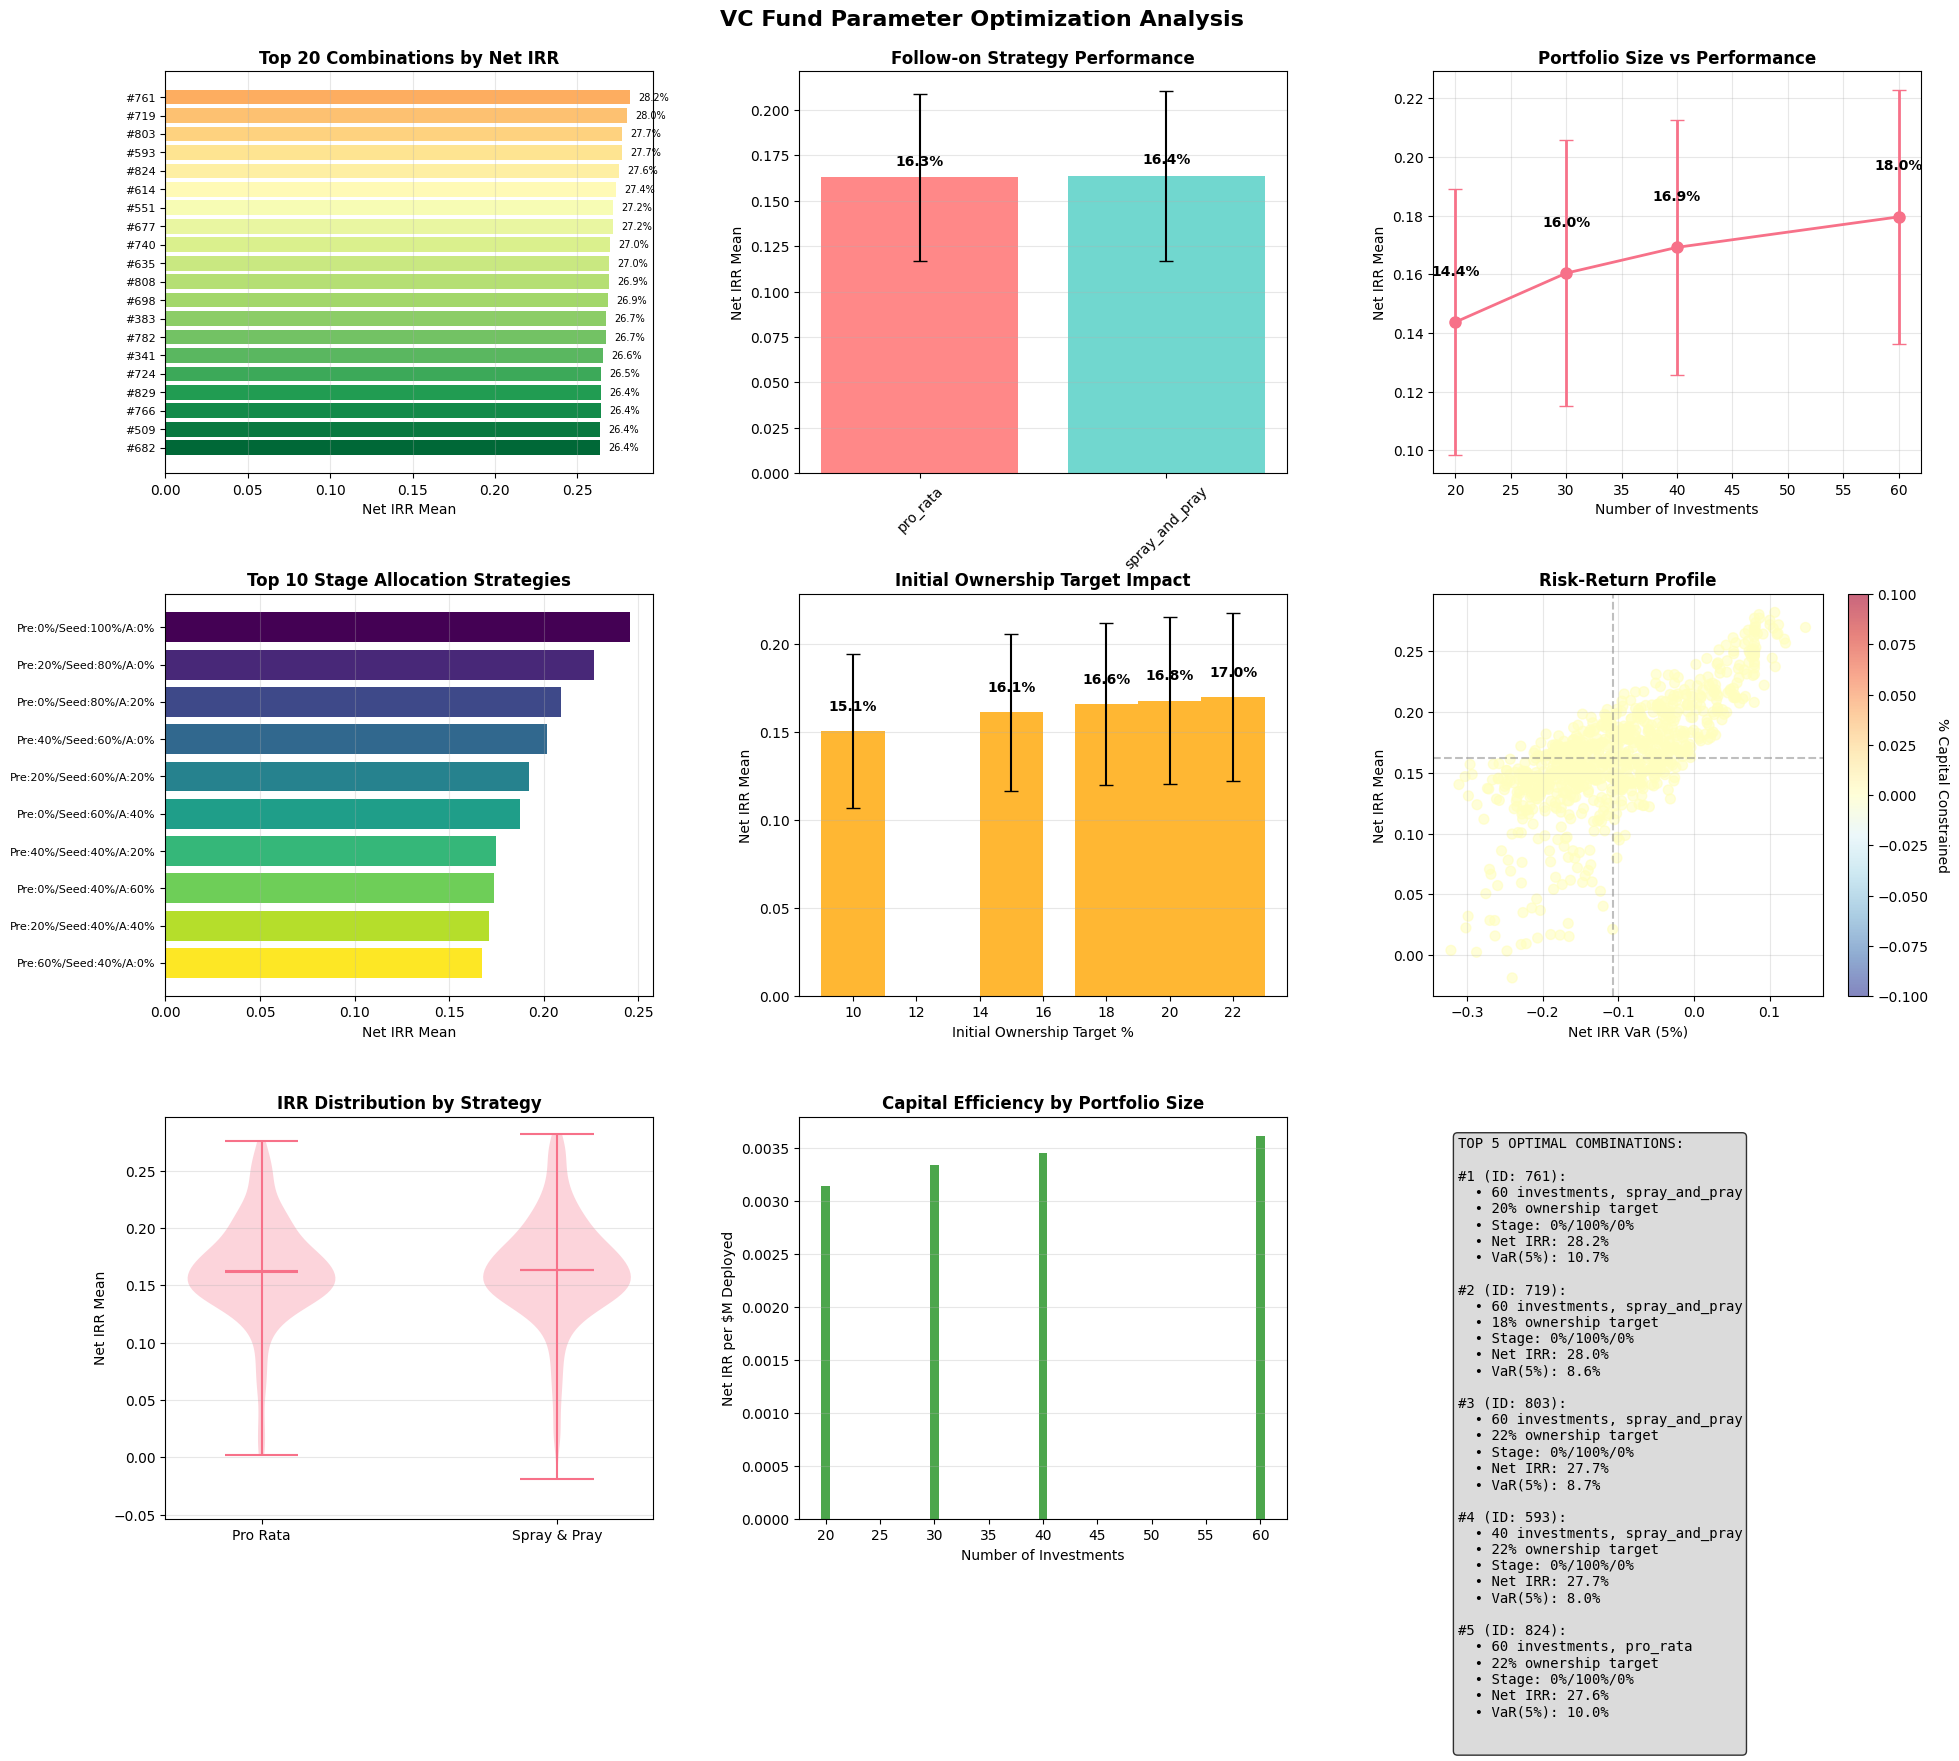


=== KEY FINDINGS ===

Overall Performance:
  Mean Net IRR: 16.3%
  Median Net IRR: 16.2%
  Best Performance: 28.2%
  Worst Performance: -1.9%

Follow-on Strategy Comparison:
  PRO_RATA:
    Mean Net IRR: 16.3%
    VaR(5%): -11.0%
    Capital Constrained: 0.0%
  SPRAY_AND_PRAY:
    Mean Net IRR: 16.4%
    VaR(5%): -9.4%
    Capital Constrained: 0.0%

Optimal Configuration (Combination #761):
  Net IRR: 28.2%
  Portfolio Size: 60 investments
  Strategy: spray_and_pray
  Ownership Target: 20%
  Stage Allocation: 0%% Pre-Seed, 100%% Seed, 0%% Series A
  VaR(5%): 10.7%
  Capital Constrained Risk: 0.0%

Parameter Impact Analysis:
  Portfolio Size vs Net IRR correlation: 0.273
  Initial Ownership Target vs Net IRR correlation: 0.146
  Stage Allocation Impact:
    Pre-Seed correlation: -0.644
    Seed correlation: 0.775
    Series A correlation: -0.131


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Read the optimization results
df = pd.read_csv('Optimization_Output.csv')

print("=== VC FUND OPTIMIZATION ANALYSIS ===")
print(f"Total combinations analyzed: {len(df)}")
print(f"Simulations per combination: {df['n_simulations'].iloc[0]}")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")
fig_size = (15, 10)

# Create comprehensive analysis
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('VC Fund Parameter Optimization Analysis', fontsize=16, fontweight='bold')

# 1. Top Performers Analysis
ax1 = axes[0, 0]
top_20 = df.nlargest(20, 'net_irr_mean')
colors = plt.cm.RdYlGn(np.linspace(0.3, 1, len(top_20)))

# Reverse the order so highest performers are at the top
bars = ax1.barh(range(len(top_20)), top_20['net_irr_mean'][::-1], color=colors[::-1])
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels([f"#{i}" for i in top_20['combination_id'][::-1]], fontsize=8)
ax1.set_xlabel('Net IRR Mean')
ax1.set_title('Top 20 Combinations by Net IRR', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_20['net_irr_mean'][::-1])):
    ax1.text(val + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{val:.1%}', ha='left', va='center', fontsize=7)

# 2. Follow-on Strategy Comparison
ax2 = axes[0, 1]
strategy_stats = df.groupby('follow_on_strategy').agg({
    'net_irr_mean': ['mean', 'median', 'std'],
    'net_irr_var_5pct': 'mean',
    'pct_capital_constrained': 'mean'
}).round(4)

strategy_means = df.groupby('follow_on_strategy')['net_irr_mean'].mean()
strategy_stds = df.groupby('follow_on_strategy')['net_irr_mean'].std()

x_pos = np.arange(len(strategy_means))
bars = ax2.bar(x_pos, strategy_means, yerr=strategy_stds, capsize=5, 
               color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(strategy_means.index, rotation=45)
ax2.set_ylabel('Net IRR Mean')
ax2.set_title('Follow-on Strategy Performance', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val, std in zip(bars, strategy_means, strategy_stds):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.1%}', ha='center', va='bottom', fontweight='bold')

# 3. Portfolio Size vs Performance
ax3 = axes[0, 2]
size_performance = df.groupby('num_investments').agg({
    'net_irr_mean': ['mean', 'std'],
    'net_irr_var_5pct': 'mean'
}).round(4)

x = size_performance.index
y = size_performance[('net_irr_mean', 'mean')]
err = size_performance[('net_irr_mean', 'std')]

ax3.errorbar(x, y, yerr=err, marker='o', capsize=5, linewidth=2, markersize=8)
ax3.set_xlabel('Number of Investments')
ax3.set_ylabel('Net IRR Mean')
ax3.set_title('Portfolio Size vs Performance', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add value labels
for xi, yi in zip(x, y):
    ax3.text(xi, yi + 0.015, f'{yi:.1%}', ha='center', va='bottom', fontweight='bold')

# 4. Stage Allocation Heatmap
ax4 = axes[1, 0]
# Create stage allocation summary
stage_summary = df.groupby(['pre_seed_allocation', 'seed_allocation', 'series_a_allocation'])['net_irr_mean'].mean().reset_index()
stage_summary['allocation_label'] = stage_summary.apply(
    lambda x: f"Pre:{x['pre_seed_allocation']:.0%}/Seed:{x['seed_allocation']:.0%}/A:{x['series_a_allocation']:.0%}", axis=1
)

# Top 10 stage allocations
top_stages = stage_summary.nlargest(10, 'net_irr_mean')
bars = ax4.barh(range(len(top_stages)), top_stages['net_irr_mean'][::-1], 
                color=plt.cm.viridis(np.linspace(0, 1, len(top_stages)))[::-1])
ax4.set_yticks(range(len(top_stages)))
ax4.set_yticklabels(top_stages['allocation_label'][::-1], fontsize=8)
ax4.set_xlabel('Net IRR Mean')
ax4.set_title('Top 10 Stage Allocation Strategies', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# 5. Initial Ownership Target vs Performance
ax5 = axes[1, 1]
ownership_performance = df.groupby('initial_ownership_target').agg({
    'net_irr_mean': ['mean', 'std'],
    'avg_contributed_capital': 'mean',
    'pct_capital_constrained': 'mean'
}).round(4)

x = ownership_performance.index * 100  # Convert to percentage
y = ownership_performance[('net_irr_mean', 'mean')]
err = ownership_performance[('net_irr_mean', 'std')]

bars = ax5.bar(x, y, yerr=err, capsize=5, width=2, alpha=0.8, color='orange')
ax5.set_xlabel('Initial Ownership Target %')
ax5.set_ylabel('Net IRR Mean')
ax5.set_title('Initial Ownership Target Impact', fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, y):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.1%}', ha='center', va='bottom', fontweight='bold')

# 6. Risk-Return Scatter
ax6 = axes[1, 2]
scatter = ax6.scatter(df['net_irr_var_5pct'], df['net_irr_mean'], 
                      c=df['pct_capital_constrained'], cmap='RdYlBu_r', 
                      alpha=0.6, s=50)
ax6.set_xlabel('Net IRR VaR (5%)')
ax6.set_ylabel('Net IRR Mean')
ax6.set_title('Risk-Return Profile', fontweight='bold')
ax6.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax6)
cbar.set_label('% Capital Constrained', rotation=270, labelpad=15)

# Add quadrant lines
ax6.axhline(df['net_irr_mean'].median(), color='gray', linestyle='--', alpha=0.5)
ax6.axvline(df['net_irr_var_5pct'].median(), color='gray', linestyle='--', alpha=0.5)

# 7. Performance Distribution by Key Parameters
ax7 = axes[2, 0]
# Violin plot of net IRR by follow-on strategy
parts = ax7.violinplot([df[df['follow_on_strategy'] == 'pro_rata']['net_irr_mean'],
                        df[df['follow_on_strategy'] == 'spray_and_pray']['net_irr_mean']], 
                       positions=[1, 2], showmeans=True, showmedians=True)

ax7.set_xticks([1, 2])
ax7.set_xticklabels(['Pro Rata', 'Spray & Pray'], fontsize=10)
ax7.set_ylabel('Net IRR Mean')
ax7.set_title('IRR Distribution by Strategy', fontweight='bold')
ax7.grid(axis='y', alpha=0.3)

# Adjust y-axis limits to provide more space
ax7.set_ylim(bottom=ax7.get_ylim()[0] - 0.02)

# 8. Capital Efficiency Analysis
ax8 = axes[2, 1]
efficiency = df['net_irr_mean'] / (df['avg_contributed_capital'] / 1e6)  # IRR per million deployed
efficiency_by_size = df.groupby('num_investments').apply(
    lambda x: (x['net_irr_mean'] / (x['avg_contributed_capital'] / 1e6)).mean()
)

bars = ax8.bar(efficiency_by_size.index, efficiency_by_size.values, 
               color='green', alpha=0.7)
ax8.set_xlabel('Number of Investments')
ax8.set_ylabel('Net IRR per $M Deployed')
ax8.set_title('Capital Efficiency by Portfolio Size', fontweight='bold')
ax8.grid(axis='y', alpha=0.3)

# Value labels removed for better visual clarity

# 9. Optimal Parameter Combinations Summary
ax9 = axes[2, 2]
ax9.axis('off')

# Get top 5 combinations
top_5 = df.nlargest(5, 'net_irr_mean')
summary_text = "TOP 5 OPTIMAL COMBINATIONS:\n\n"
for i, (_, row) in enumerate(top_5.iterrows()):
    summary_text += f"#{i+1} (ID: {row['combination_id']}):\n"
    summary_text += f"  • {row['num_investments']} investments, {row['follow_on_strategy']}\n"
    summary_text += f"  • {row['initial_ownership_target']:.0%} ownership target\n"
    summary_text += f"  • Stage: {row['pre_seed_allocation']:.0%}/{row['seed_allocation']:.0%}/{row['series_a_allocation']:.0%}\n"
    summary_text += f"  • Net IRR: {row['net_irr_mean']:.1%}\n"
    summary_text += f"  • VaR(5%): {row['net_irr_var_5pct']:.1%}\n\n"

ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout(pad=2.0)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

# Statistical Summary
print("\n=== KEY FINDINGS ===")

# 1. Overall Performance Statistics
print(f"\nOverall Performance:")
print(f"  Mean Net IRR: {df['net_irr_mean'].mean():.1%}")
print(f"  Median Net IRR: {df['net_irr_mean'].median():.1%}")
print(f"  Best Performance: {df['net_irr_mean'].max():.1%}")
print(f"  Worst Performance: {df['net_irr_mean'].min():.1%}")

# 2. Follow-on Strategy Analysis
print(f"\nFollow-on Strategy Comparison:")
for strategy in df['follow_on_strategy'].unique():
    strategy_df = df[df['follow_on_strategy'] == strategy]
    print(f"  {strategy.upper()}:")
    print(f"    Mean Net IRR: {strategy_df['net_irr_mean'].mean():.1%}")
    print(f"    VaR(5%): {strategy_df['net_irr_var_5pct'].mean():.1%}")
    print(f"    Capital Constrained: {strategy_df['pct_capital_constrained'].mean():.1%}")

# 3. Optimal Parameters
best_combo = df.loc[df['net_irr_mean'].idxmax()]
print(f"\nOptimal Configuration (Combination #{best_combo['combination_id']}):")
print(f"  Net IRR: {best_combo['net_irr_mean']:.1%}")
print(f"  Portfolio Size: {best_combo['num_investments']} investments")
print(f"  Strategy: {best_combo['follow_on_strategy']}")
print(f"  Ownership Target: {best_combo['initial_ownership_target']:.0%}")
print(f"  Stage Allocation: {best_combo['pre_seed_allocation']:.0%}% Pre-Seed, {best_combo['seed_allocation']:.0%}% Seed, {best_combo['series_a_allocation']:.0%}% Series A")
print(f"  VaR(5%): {best_combo['net_irr_var_5pct']:.1%}")
print(f"  Capital Constrained Risk: {best_combo['pct_capital_constrained']:.1%}")

# 4. Parameter Impact Analysis
print(f"\nParameter Impact Analysis:")

# Portfolio size impact
size_corr = df['num_investments'].corr(df['net_irr_mean'])
print(f"  Portfolio Size vs Net IRR correlation: {size_corr:.3f}")

# Initial ownership target impact
ownership_corr = df['initial_ownership_target'].corr(df['net_irr_mean'])
print(f"  Initial Ownership Target vs Net IRR correlation: {ownership_corr:.3f}")

# Stage allocation impact
print(f"  Stage Allocation Impact:")
print(f"    Pre-Seed correlation: {df['pre_seed_allocation'].corr(df['net_irr_mean']):.3f}")
print(f"    Seed correlation: {df['seed_allocation'].corr(df['net_irr_mean']):.3f}")
print(f"    Series A correlation: {df['series_a_allocation'].corr(df['net_irr_mean']):.3f}")